# Summary


In [5]:
#Install Packages
!pip install app-store-scraper
!pip install wordcloud

#Import Libraries
from app_store_scraper import AppStore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import json,os,uuid
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbkhn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [21]:
#Collect all the ChatGPT reviews from App Store
a_reviews = AppStore('us','instagram','389801252')
a_reviews.review(sleep=1)

2023-10-30 00:23:01,081 [INFO] Base - Initialised: AppStore('us', 'instagram', 389801252)
2023-10-30 00:23:01,083 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/instagram/id389801252
2023-10-30 00:23:07,448 [INFO] Base - [id:389801252] Fetched 60 reviews (60 fetched in total)
2023-10-30 00:23:36,729 [INFO] Base - [id:389801252] Fetched 120 reviews (120 fetched in total)
2023-10-30 00:24:21,654 [INFO] Base - [id:389801252] Fetched 160 reviews (160 fetched in total)
2023-10-30 00:24:42,234 [ERROR] Base - Something went wrong: HTTPSConnectionPool(host='amp-api.apps.apple.com', port=443): Max retries exceeded with url: /v1/catalog/us/apps/389801252/reviews?l=en-GB&offset=160&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac (Caused by ResponseError('too many 404 error responses'))
2023-10-30 00:24:42,234 [INFO] Base - [id:389801252] Fetched 160 reviews (160 fetched in total)


In [25]:
data = pd.DataFrame(np.array(a_reviews.reviews),columns=['review'])
data = data.join(pd.DataFrame(data.pop('review').tolist()))
data.head()

,date,review,rating,isEdited,title,userName
0,2023-09-25 11:55:44,"Dear Instagram, i don't wanna be mean but I ha...",5,False,Instagram please give me the feature to add m...,rezajbrock
1,2023-09-23 20:04:27,Dear Instagram\n\nI don't wanna be mean but I ...,5,False,Instagram please give me the feature to add mu...,Wantinmor_gan
2,2023-08-12 16:38:44,"Dear Instagram, i don't wanna be mean but I ha...",5,False,Instagram please give me the feature to add mu...,Daaantee🧍🏻‍♂️
3,2023-09-27 13:48:50,"Dear Instagram, i don't wanna be mean but I ha...",5,False,Instagram please give me the feature to add mu...,uloserrr
4,2023-09-26 03:02:06,Dear Instagram\nI don't wanna be mean but I ha...,5,False,Instagram please give me the feature to add mu...,______Kay_______


In [26]:
data.shape

(160, 6)

In [22]:
data.drop(['isEdited','userName'],axis=1,inplace=True) #Delete columns
data = data[['date','title','review','rating']] #Rearrange columns
data.head()

,date,title,review,rating
0,2023-09-25 11:55:44,Instagram please give me the feature to add m...,"Dear Instagram, i don't wanna be mean but I ha...",5
1,2023-09-23 20:04:27,Instagram please give me the feature to add mu...,Dear Instagram\n\nI don't wanna be mean but I ...,5
2,2023-08-12 16:38:44,Instagram please give me the feature to add mu...,"Dear Instagram, i don't wanna be mean but I ha...",5
3,2023-09-27 13:48:50,Instagram please give me the feature to add mu...,"Dear Instagram, i don't wanna be mean but I ha...",5
4,2023-09-26 03:02:06,Instagram please give me the feature to add mu...,Dear Instagram\nI don't wanna be mean but I ha...,5


In [23]:
data.to_excel('instagram_reviews.xlsx', index=False)

In [24]:
data.to_csv('instagram_reviews.csv', index=False)

In [27]:
data.head()

,date,review,rating,isEdited,title,userName
0,2023-09-25 11:55:44,"Dear Instagram, i don't wanna be mean but I ha...",5,False,Instagram please give me the feature to add m...,rezajbrock
1,2023-09-23 20:04:27,Dear Instagram\n\nI don't wanna be mean but I ...,5,False,Instagram please give me the feature to add mu...,Wantinmor_gan
2,2023-08-12 16:38:44,"Dear Instagram, i don't wanna be mean but I ha...",5,False,Instagram please give me the feature to add mu...,Daaantee🧍🏻‍♂️
3,2023-09-27 13:48:50,"Dear Instagram, i don't wanna be mean but I ha...",5,False,Instagram please give me the feature to add mu...,uloserrr
4,2023-09-26 03:02:06,Dear Instagram\nI don't wanna be mean but I ha...,5,False,Instagram please give me the feature to add mu...,______Kay_______


# EDA

In [28]:
data = pd.read_csv('instagram_reviews.csv')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    120 non-null    object
 1   title   120 non-null    object
 2   review  120 non-null    object
 3   rating  120 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 3.9+ KB


In [30]:
data.shape

(120, 4)

In [31]:
data.describe()

,rating
count,120.000000
mean,4.800000
std,0.528197
min,3.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [32]:
data.describe(include='object')

,date,title,review
count,120,120,120
unique,120,108,101
top,2023-09-25 11:55:44,Instagram please give me the feature to add mu...,"Dear Instagram,\ni don't wanna be mean but I h..."
freq,1,7,6


Analysis of Rating Column

In [33]:
#Rating Distribution
data['rating'].value_counts().sort_index()

3      7
4     10
5    103
Name: rating, dtype: int64

In [34]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

3     5.83
4     8.33
5    85.83
Name: rating, dtype: float64

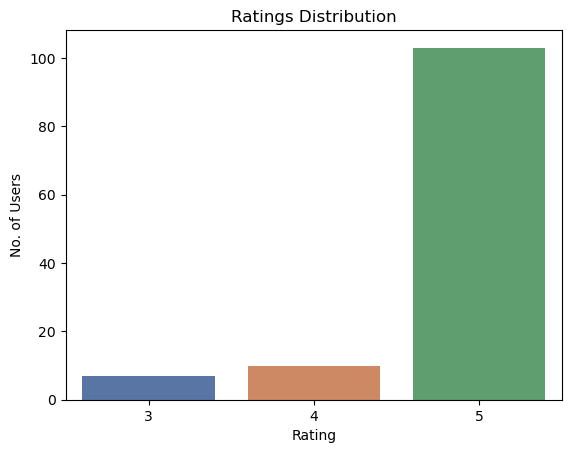

In [35]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

# Data Preprocessing

In [36]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

date      0
title     0
review    0
rating    0
dtype: int64

In [37]:
#Combine Review Time and Review
data['complete_review'] = data['title'] +' .'+data['review']

In [38]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['date','review','title']
data = data.drop(remove_cols,axis='columns')

In [39]:
data.head()

,rating,complete_review
0,5,Instagram please give me the feature to add m...
1,5,Instagram please give me the feature to add mu...
2,5,Instagram please give me the feature to add mu...
3,5,Instagram please give me the feature to add mu...
4,5,Instagram please give me the feature to add mu...


1. Convert all the reviews to lowercase

In [40]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0    instagram please give me the feature to add mu...
1    instagram please give me the feature to add mu...
2    instagram please give me the feature to add mu...
3    instagram please give me the feature to add mu...
4    instagram please give me the feature to add mu...
Name: complete_review, dtype: object

2. Remove Punctuation

In [41]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

3. Remove Emojis

In [42]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

4. Remove Stopwords

Stopwords are commonly used words (i.e. “the”, “a”, “an”) that do not add meaning to a sentence and can be ignored without having a drastic effect on the meaning of the sentence.

In [43]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

5. Apply Lemmatization

In [44]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)

NameError: name 'nlp' is not defined

6. Remove certain words

  These are specific to app and won't show any sentiments

In [45]:
#words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','iphone','ipad','gpt4','phone','number','ai','use','io']
#data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

7. Map ratings to positive, negative & neutral sentiment

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment


In [46]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,rating,complete_review,sentiment
0,5,instagram please give feature add music notes ...,2
1,5,instagram please give feature add music notes ...,2
2,5,instagram please give feature add music notes ...,2
3,5,instagram please give feature add music notes ...,2
4,5,instagram please give feature add music notes ...,2


In [47]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

2    94.17
1     5.83
Name: sentiment, dtype: float64

Data is Imbalanced as about 66% of sentiment is positive, 24% is negative and 9.5% is neutral.

# Reviews Analysis

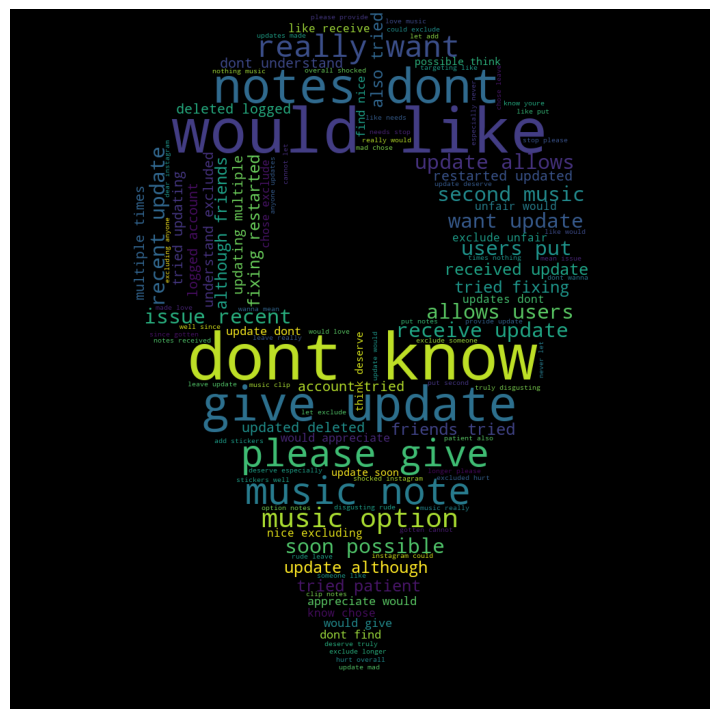

In [53]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
mask = np.array(Image.open("loc.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('review_sentiment.png')
plt.show()

In [54]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

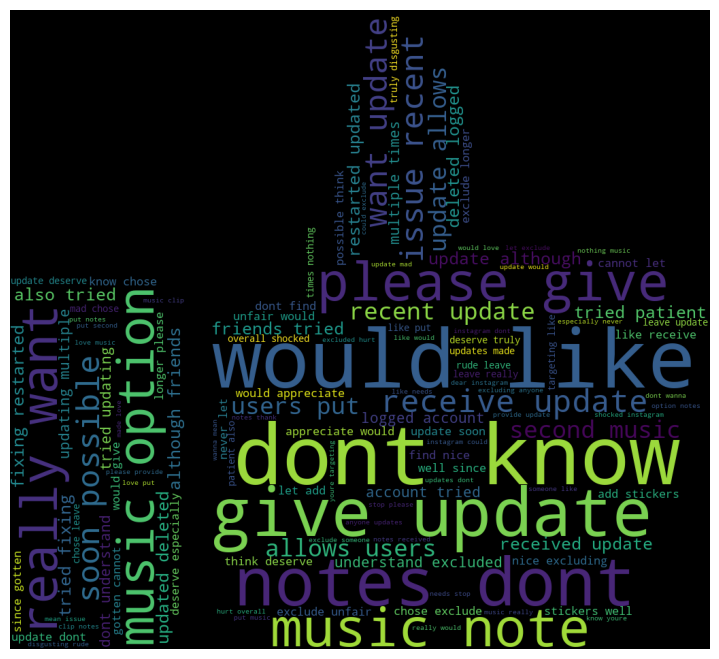

In [55]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
mask = np.array(Image.open("thumbs_up.png"))
wordcloud = WordCloud(width = 2200, height = 2300,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('positive_sentiment.png')
plt.show()
wordcloud.to_file("posid.png")

In [56]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
mask = np.array(Image.open("./thumbs_down.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='#E0E0E0',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('negative_sentiment.png')
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

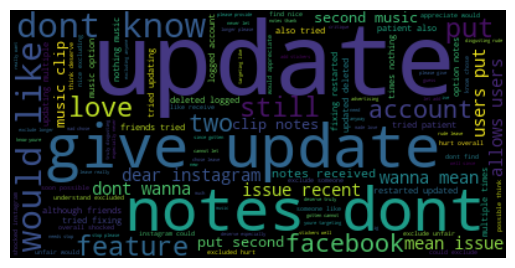

In [57]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis Model


<h3> Bag of Word Vectorization </h3>

In [58]:
#Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
X = cv.fit_transform(data['complete_review'])
y = data['sentiment']

Handle Imbalanced Data

In [59]:
# Instantiate the SMOTE object
smote = SMOTE()

# Perform oversampling
X_oversampled, y_oversampled = smote.fit_resample(X, y)

Train, Test Split

In [60]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_oversampled,y_oversampled,test_size=0.15,random_state=17,stratify=y_oversampled)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(192, 527)
(34, 527)
(192,)
(34,)


<h3> Multinomial Naive Bayes </h3>

In [61]:
#Training the model
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.29      0.71      0.42         7
           2       0.88      0.56      0.68        27

    accuracy                           0.59        34
   macro avg       0.59      0.63      0.55        34
weighted avg       0.76      0.59      0.63        34



Logistic Regression

In [62]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.82      0.70      0.76        20
           2       0.65      0.79      0.71        14

    accuracy                           0.74        34
   macro avg       0.74      0.74      0.73        34
weighted avg       0.75      0.74      0.74        34



<h3> Random Forest </h3>

In [63]:
# Initialize and train the random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.94      0.76      0.84        21
           2       0.71      0.92      0.80        13

    accuracy                           0.82        34
   macro avg       0.82      0.84      0.82        34
weighted avg       0.85      0.82      0.83        34



XGBoost

In [64]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_test))

              precision    recall  f1-score   support

           1       0.88      1.00      0.94        15
           2       1.00      0.89      0.94        19

    accuracy                           0.94        34
   macro avg       0.94      0.95      0.94        34
weighted avg       0.95      0.94      0.94        34



#Conclusion

The best-performing model was identified as XGBoost, which achieved an accuracy of 87% with the f1-score of 0.85 and above for all the labels(positive,negative & neutral). This model demonstrates the ability to accurately predict sentiment based on ChatGPT iOS reviews.

Overall, with the developed sentiment analysis model, we can effectively analyze and understand the sentiment expressed in ChatGPT reviews. This provides valuable insights for businesses, helping them make informed decisions, improve customer satisfaction, and enhance their products and services based on customer feedback.